![](https://web.archive.org/web/20161019192412im_/http://lisp.vse.cz/pkdd99/data.gif)

[Guide to the Financial Data Set](https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm)
    
[1999 Czech Financial Dataset - Real Anonymized Transactions](https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions)

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier 
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.features.importances import FeatureImportances
from xgboost import XGBClassifier

In [2]:
district_df = pd.read_csv('berka/district.csv', delimiter= ";", 
                          names = ["district code", "district name", "region", "no. of inhabitants", 
                          "no. of municipalities with inhabitants < 499", 
                          "no. of municipalities with inhabitants 500-1999", 
                          "no. of municipalities with inhabitants 2000-9999",
                          "no. of municipalities with inhabitants >10000", 
                          "no. of cities", "ratio of urban inhabitants" , "average salary",
                          "unemploymant rate 95", "unemploymant rate 96", 
                          "no. of enterpreneurs per 1000 inhabitants", "no. of commited crimes 95",
                          "no. of commited crimes 96"], )

In [3]:
district_df = district_df.drop(0, axis = 0)

In [4]:
# Each csv file in the dataset was semi colon delimited and we are now loading into a dataframe
district_df['district code'] = district_df['district code'].astype(int)
account_df = pd.read_csv('berka/account.csv', delimiter=';')
client_df = pd.read_csv('berka/client.csv', delimiter=';')
card_df = pd.read_csv('berka/card.csv', delimiter=';')
disp_df = pd.read_csv('berka/disp.csv', delimiter=';')
loan_df = pd.read_csv('berka/loan.csv', delimiter=';')
order_df = pd.read_csv('berka/order.csv', delimiter=';')
trans_df = pd.read_csv('berka/trans.csv', delimiter=';')

/home/m/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# we are now connecting all of the dataframes and will be merged below into one called dfs
df1 = pd.merge(account_df, loan_df, left_on='account_id', right_on='account_id', how='inner')
df2 = pd.merge(account_df, order_df, left_on='account_id', right_on='account_id', how='inner')
df3 = pd.merge(account_df, trans_df, left_on='account_id', right_on='account_id', how='inner')
df4 = pd.merge(account_df, district_df, left_on='district_id', right_on='district code', how='inner')
df5 = pd.merge(account_df, disp_df, left_on='account_id', right_on='account_id', how='inner')
df = pd.merge(disp_df, card_df, left_on='disp_id', right_on='disp_id', how='inner')
df6 = pd.merge(account_df, df, left_on='account_id', right_on='account_id', how='inner')
df = pd.merge(disp_df, client_df, left_on='client_id', right_on='client_id', how='inner')
df7 = pd.merge(account_df, df, left_on='account_id', right_on='account_id', how='inner')

In [6]:
from functools import reduce

In [7]:
dfs = [df1, df2, df3, df4, df5, df6, df7]

In [8]:

dataframe = reduce(lambda left,right: pd.merge(left, right, on = "account_id"), dfs)

In [9]:
data = dataframe[['account_id', 'loan_id', 'duration', 'payments', 'status', 'order_id', 'bank_to',
                  'account_to', 'trans_id', 'operation', 'amount', 'balance', 'bank', 'account',
                  'district code', 'district name', 'region', 'no. of inhabitants',
                  'no. of municipalities with inhabitants < 499',
                  'no. of municipalities with inhabitants 500-1999',
                  'no. of municipalities with inhabitants 2000-9999', 
                  'no. of municipalities with inhabitants >10000', 
                  'no. of cities', 'ratio of urban inhabitants', 'average salary', 
                  'unemploymant rate 95', 'unemploymant rate 96', 'no. of enterpreneurs per 1000 inhabitants', 
                  'no. of commited crimes 95', 'no. of commited crimes 96', 'card_id', 'issued', 
                  'frequency', 'date', 'disp_id', 'client_id', 'type', 'birth_number']]
data.head()

,account_id,loan_id,duration,payments,status,order_id,bank_to,account_to,trans_id,operation,...,no. of commited crimes 95,no. of commited crimes 96,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,5891,6202,12,5432.0,A,38118,EF,95617645,1736607,VKLAD,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
1,5891,6202,12,5432.0,A,38118,EF,95617645,1736609,PREVOD Z UCTU,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
2,5891,6202,12,5432.0,A,38118,EF,95617645,1736950,VYBER,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
3,5891,6202,12,5432.0,A,38118,EF,95617645,3673340,NaN,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
4,5891,6202,12,5432.0,A,38118,EF,95617645,1736610,PREVOD Z UCTU,...,18721,18696,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929


In [10]:
data.shape

(174249, 38)

In [11]:
data.isna().sum()

account_id                                               0
loan_id                                                  0
duration                                                 0
payments                                                 0
status                                                   0
order_id                                                 0
bank_to                                                  0
account_to                                               0
trans_id                                                 0
operation                                            24197
amount                                                   0
balance                                                  0
bank                                                120490
account                                             107567
district code                                            0
district name                                            0
region                                                  

In [12]:
# Let's drop the columns with missing data

In [13]:
data = data.drop(['operation', 'bank', 'account'], axis = 1)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174249 entries, 0 to 174248
Data columns (total 35 columns):
account_id                                          174249 non-null int64
loan_id                                             174249 non-null int64
duration                                            174249 non-null int64
payments                                            174249 non-null float64
status                                              174249 non-null object
order_id                                            174249 non-null int64
bank_to                                             174249 non-null object
account_to                                          174249 non-null int64
trans_id                                            174249 non-null int64
amount                                              174249 non-null float64
balance                                             174249 non-null float64
district code                                       174249 non-null

In [15]:
data = data.replace('?', np.nan)

In [16]:
data.isna().sum()

account_id                                             0
loan_id                                                0
duration                                               0
payments                                               0
status                                                 0
order_id                                               0
bank_to                                                0
account_to                                             0
trans_id                                               0
amount                                                 0
balance                                                0
district code                                          0
district name                                          0
region                                                 0
no. of inhabitants                                     0
no. of municipalities with inhabitants < 499           0
no. of municipalities with inhabitants 500-1999        0
no. of municipalities with inha

In [17]:
data[['account_id', 'loan_id', 'duration', 'status', 'order_id', 'bank_to', 'account_to', 'trans_id', 
      'district code', 'district name', 'region', 'card_id', 'issued', 'frequency', 'date', 'disp_id',
      'client_id', 'type', 'birth_number']] = data[['account_id', 'loan_id', 'duration', 'status',
                                                    'order_id', 'bank_to', 'account_to', 'trans_id',
                                                    'district code', 'district name', 'region', 'card_id', 
                                                    'issued', 'frequency', 'date', 'disp_id', 'client_id', 
                                                    'type', 'birth_number']].astype(object)

In [18]:
data[['payments', 'amount', 'balance', 'ratio of urban inhabitants', 'average salary', 'unemploymant rate 95',
      'unemploymant rate 96', 'no. of commited crimes 95', 
      'no. of commited crimes 96']] = data[['payments', 'amount', 'balance', 
                                            'ratio of urban inhabitants', 'average salary', 
                                            'unemploymant rate 95', 'unemploymant rate 96', 
                                            'no. of commited crimes 95', 
                                            'no. of commited crimes 96']].astype(float)

In [19]:
data[['no. of inhabitants', 'no. of municipalities with inhabitants < 499', 
      'no. of municipalities with inhabitants 500-1999', 
      'no. of municipalities with inhabitants 2000-9999', 
      'no. of municipalities with inhabitants >10000', 
      'no. of cities']] = data[['no. of inhabitants','no. of municipalities with inhabitants < 499', 
                                'no. of municipalities with inhabitants 500-1999', 
                                'no. of municipalities with inhabitants 2000-9999',
                                'no. of municipalities with inhabitants >10000', 'no. of cities']].astype(int)

In [20]:
data["unemploymant rate 95"] = data["unemploymant rate 95"].fillna(np.mean(data["unemploymant rate 95"]))
data['no. of commited crimes 95'] = data['no. of commited crimes 95'].fillna(np.mean(data['no. of commited crimes 95']))

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174249 entries, 0 to 174248
Data columns (total 35 columns):
account_id                                          174249 non-null object
loan_id                                             174249 non-null object
duration                                            174249 non-null object
payments                                            174249 non-null float64
status                                              174249 non-null object
order_id                                            174249 non-null object
bank_to                                             174249 non-null object
account_to                                          174249 non-null object
trans_id                                            174249 non-null object
amount                                              174249 non-null float64
balance                                             174249 non-null float64
district code                                       174249 no

In [22]:
data_num = data.select_dtypes(exclude = ['object'])
data_cat = data.select_dtypes(include = ['object'])

In [23]:
data_cat.shape, data_num.shape

((174249, 20), (174249, 15))

In [24]:
data_num.head()

,payments,amount,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate 95,unemploymant rate 96,no. of commited crimes 95,no. of commited crimes 96
0,5432.0,900.0,900.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0
1,5432.0,32594.0,33494.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0
2,5432.0,4500.0,28994.0,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0
3,5432.0,21.6,29015.6,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0
4,5432.0,32594.0,61609.6,387570,0,0,0,1,1,100.0,9897.0,1.6,1.96,18721.0,18696.0


In [25]:
data_cat.head()

,account_id,loan_id,duration,status,order_id,bank_to,account_to,trans_id,district code,district name,region,no. of enterpreneurs per 1000 inhabitants,card_id,issued,frequency,date,disp_id,client_id,type,birth_number
0,5891,6202,12,A,38118,EF,95617645,1736607,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
1,5891,6202,12,A,38118,EF,95617645,1736609,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
2,5891,6202,12,A,38118,EF,95617645,1736950,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
3,5891,6202,12,A,38118,EF,95617645,3673340,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929
4,5891,6202,12,A,38118,EF,95617645,1736610,54,Brno - mesto,south Moravia,140,874,971007 00:00:00,POPLATEK MESICNE,930125,7127,7127,OWNER,570929


In [26]:
data_cat.duration.value_counts()

12    55188
60    36052
24    29432
48    28378
36    25199
Name: duration, dtype: int64

In [27]:
data_cat.type.value_counts()

OWNER        128019
DISPONENT     46230
Name: type, dtype: int64

In [28]:
data_cat.status.value_counts()

C    87493
A    83278
B     2526
D      952
Name: status, dtype: int64

In [29]:
data_cat.frequency.value_counts()

POPLATEK MESICNE      153477
POPLATEK TYDNE         16717
POPLATEK PO OBRATU      4055
Name: frequency, dtype: int64

In [30]:
def check_value_counts(x):
    return len(x.value_counts())

In [31]:
data_cat.apply(lambda x: check_value_counts(x))

account_id                                     170
loan_id                                        170
duration                                         5
status                                           4
order_id                                       354
bank_to                                         13
account_to                                     351
trans_id                                     47127
district code                                   60
district name                                   60
region                                           8
no. of enterpreneurs per 1000 inhabitants       36
card_id                                        170
issued                                         160
frequency                                        3
date                                           162
disp_id                                        206
client_id                                      206
type                                             2
birth_number                   

In [32]:
data_cat_dum = pd.get_dummies(data_cat[['duration', 'status', 'bank_to', 'region','frequency','type']])

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [34]:
data_num_sca = scaler.fit_transform(data_num)

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/m/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [35]:
data_num_sca = pd.DataFrame(data_num_sca, index = data_num.index, columns = data_num.columns)

In [36]:
data_new = pd.concat([data_cat_dum, data_num_sca], axis = 1)

In [37]:
data_new.shape

(174249, 50)

In [38]:
pd.DataFrame((np.random.random(len(data)) < .05).astype(int))[0].value_counts()

0    165364
1      8885
Name: 0, dtype: int64

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA()
pca.fit(data_new)
features = range(pca.n_components_)

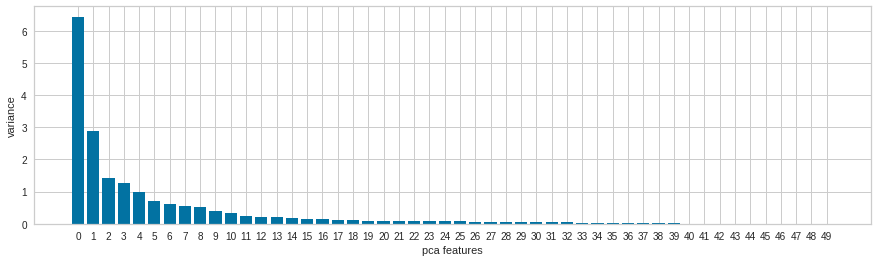

In [41]:
plt.figure(figsize = (15,4))
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('pca features')
plt.show()

In [42]:
pca = PCA(n_components = 2).fit(data_new)

In [43]:
data_new_pca = pca.transform(data_new)

In [44]:
data_new_pca

array([[ 2.71351876,  0.18095986],
       [ 2.66727558,  0.3644975 ],
       [ 2.68302506,  0.26666738],
       ...,
       [-1.03763393,  2.38163658],
       [-1.09338996,  2.59792743],
       [-1.07778887,  2.47609954]])

In [45]:
from sklearn.cluster import KMeans

In [46]:
kmeans = KMeans(n_clusters = 10)

In [47]:
kmeans.fit(data_new_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [48]:
labels = kmeans.predict(data_new_pca)

In [49]:
labels

array([9, 9, 9, ..., 6, 6, 6], dtype=int32)

In [50]:
cluster_numbers =  pd.DataFrame(pd.DataFrame(labels)[0].value_counts())
cluster_numbers.T

,5,1,7,0,3,8,2,4,6,9
0,48737,24383,18275,17456,16745,13605,12461,11787,7075,3725


In [51]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


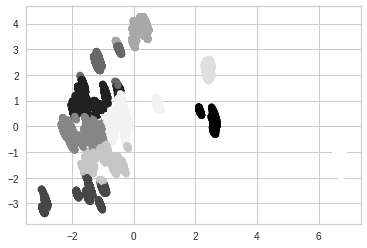

In [52]:
plt.scatter(x =(data_new_pca)[:,0], y = (data_new_pca)[:,1], marker = 'o', c = labels)
plt.legend()
plt.show()

In [53]:
to_plot = pd.concat([pd.DataFrame(data_new_pca, columns= ['x', 'y']), pd.DataFrame(labels, columns= ['label'])], axis = 1)# 

In [54]:
import seaborn as sns

/home/m/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


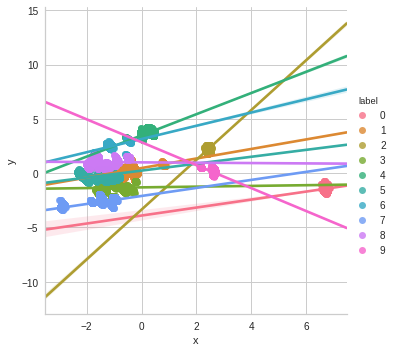

In [55]:
sns.lmplot(data = to_plot, x = 'x', y = 'y', hue = 'label' , legend = True)
plt.show()

In [56]:
cluster3725, = cluster_numbers.index[cluster_numbers[0] == 3725] # storing our cluster in variable, so it will 
# be fixed eveytime we run this kernel

In [57]:
sb = pd.DataFrame(labels, columns= ['label'])

In [58]:
sb['flag'] = 0

In [59]:
sb.flag[sb.label == cluster3725] = 1

/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
sb.flag.value_counts()

0    170524
1      3725
Name: flag, dtype: int64

In [61]:
## Classification is performed below

In [62]:
data_new_sb = pd.concat([data_new, sb.flag], axis= 1)
data_new_pca_sb = pd.concat([pd.DataFrame(data_new_pca), sb.flag], axis= 1)

In [63]:
X = data_new_sb.drop('flag', axis = 1)
y = data_new_sb.flag

X_pca = data_new_pca_sb.drop('flag', axis = 1)
y_pca = data_new_pca_sb.flag

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size = 0.2, random_state = 1)

In [65]:
#using model_fit for the regular dataset with all columns of data

In [66]:
def model_fit(x):
    x.fit(X_train, y_train)
    y_pred = x.predict(X_test)
    model_fit.accuracy = accuracy_score(y_pred, y_test)
    print('Accuracy Score',accuracy_score(y_pred, y_test))
    print(classification_report(y_pred, y_test))
    print('Confusion Matrix \n',confusion_matrix(y_pred, y_test))

In [67]:
model_fit(KNeighborsClassifier(n_neighbors = 4))
KNN = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34098
           1       1.00      1.00      1.00       752

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34098     0]
 [    0   752]]


In [68]:
from sklearn.linear_model import LogisticRegression
model_fit(LogisticRegression())
Logistic = model_fit.accuracy

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34098
           1       1.00      1.00      1.00       752

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34098     0]
 [    0   752]]


In [69]:
from sklearn.naive_bayes import GaussianNB
model_fit(GaussianNB())
Gaussian = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34098
           1       1.00      1.00      1.00       752

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34098     0]
 [    0   752]]


In [70]:
from sklearn import tree
model_fit(tree.DecisionTreeClassifier())
Tree = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34098
           1       1.00      1.00      1.00       752

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34098     0]
 [    0   752]]


In [71]:
from sklearn.ensemble import RandomForestClassifier
model_fit(RandomForestClassifier(n_estimators = 100, max_depth =10, random_state = 1))
RandomForest = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34098
           1       1.00      1.00      1.00       752

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34098     0]
 [    0   752]]


In [72]:
m = RandomForestClassifier().fit(X_train, y_train)

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


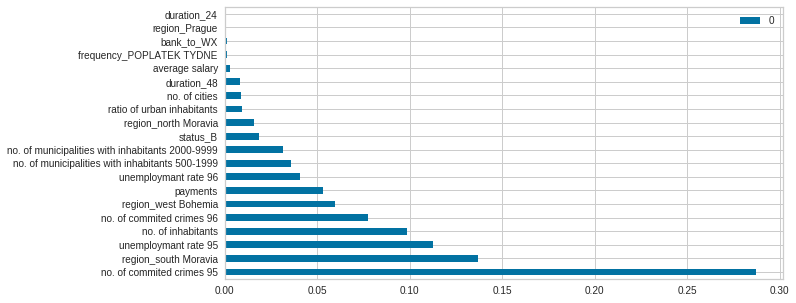

In [73]:
x = pd.DataFrame(m.feature_importances_, X_train.columns)
pd.DataFrame(x[0].sort_values(ascending = False)[0:20]).iloc[:,:1].plot.barh(figsize=(10,5))
plt.show()

In [74]:
scores_list_1 = ['KNN','Logistic','Gaussian','Tree','RandomForest']
scores_1 = [KNN, Logistic, Gaussian, Tree, RandomForest, ]

In [75]:
score_df_classification = pd.DataFrame([scores_list_1, scores_1]).T

In [76]:
score_df_classification.index = score_df_classification[0]
del score_df_classification[0]
score_df_classification

,1
0,
KNN,1
Logistic,1
Gaussian,1
Tree,1
RandomForest,1


In [77]:
#using model_fit for the pca dataset with all columns of data

In [78]:
def model_fit(x):
    x.fit(X_train_pca, y_train_pca)
    y_pred = x.predict(X_test_pca)
    model_fit.accuracy = accuracy_score(y_pred, y_test_pca)
    print('Accuracy Score',accuracy_score(y_pred, y_test_pca))
    print(classification_report(y_pred, y_test_pca))
    print('Confusion Matrix \n',confusion_matrix(y_pred, y_test_pca))

In [79]:
model_fit(KNeighborsClassifier(n_neighbors = 4))
KNN = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34098
           1       1.00      1.00      1.00       752

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34098     0]
 [    0   752]]


In [80]:
model_fit(LogisticRegression())
Logistic = model_fit.accuracy

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score 0.9784218077474892
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     34850
           1       0.00      0.00      0.00         0

   micro avg       0.98      0.98      0.98     34850
   macro avg       0.50      0.49      0.49     34850
weighted avg       1.00      0.98      0.99     34850

Confusion Matrix 
 [[34098   752]
 [    0     0]]


/home/m/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/m/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/m/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [81]:
model_fit(GaussianNB())
Gaussian = model_fit.accuracy

Accuracy Score 0.9858823529411764
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     34590
           1       0.35      1.00      0.51       260

   micro avg       0.99      0.99      0.99     34850
   macro avg       0.67      0.99      0.75     34850
weighted avg       1.00      0.99      0.99     34850

Confusion Matrix 
 [[34098   492]
 [    0   260]]


In [82]:
model_fit(tree.DecisionTreeClassifier())
Tree = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34098
           1       1.00      1.00      1.00       752

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34098     0]
 [    0   752]]


In [83]:
model_fit(RandomForestClassifier(n_estimators = 100, max_depth =10, random_state = 1))
RandomForest = model_fit.accuracy

Accuracy Score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34098
           1       1.00      1.00      1.00       752

   micro avg       1.00      1.00      1.00     34850
   macro avg       1.00      1.00      1.00     34850
weighted avg       1.00      1.00      1.00     34850

Confusion Matrix 
 [[34098     0]
 [    0   752]]


In [84]:
scores_list_1 = ['KNN','Logistic','Gaussian','Tree','RandomForest']
scores_1 = [KNN, Logistic, Gaussian, Tree, RandomForest ]

In [85]:
score_df_classification = pd.DataFrame([scores_list_1, scores_1]).T

In [86]:
score_df_classification.index = score_df_classification[0]
del score_df_classification[0]
score_df_classification

,1
0,
KNN,1
Logistic,0.978422
Gaussian,0.985882
Tree,1
RandomForest,1


In [87]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [88]:
# Implementing the ROC curve on the logistic regression.  
prob_lr = LogisticRegression().fit(X_train_pca, y_train_pca).predict_proba(X_test_pca)

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [89]:
#This will give us two scores.  We have extracted the second score and we are storing in prob_lr
prob_lr = [p[1] for p in prob_lr]

In [90]:
#Verifying the last five scores in prob_lr
prob_lr[:5]

[0.008649193859041775,
 0.017083310309166887,
 0.04919581799525547,
 0.012797456523542222,
 0.006913626065292777]

In [91]:
# The ROC is also giving us an accuracy of one.  We can assume that the model was not overfit and that the 
# imbalance is not impacting the results
roc_auc_score(y_test, prob_lr)

0.7758478222345355

In [92]:
#plotting the ROC and AUC score
fpr, tpr, threshold = roc_curve(y_test_pca, prob_lr)

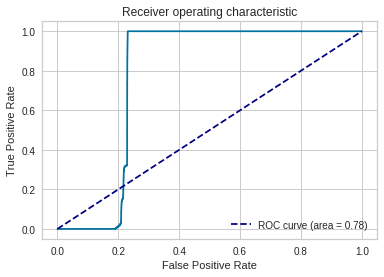

In [93]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--', label = 'ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

In [94]:
data_new_pca_sb.flag.value_counts()

0    170524
1      3725
Name: flag, dtype: int64

In [95]:
from sklearn.utils import resample

In [96]:
majority = data_new_pca_sb[data_new_pca_sb.flag == 0]
minority = data_new_pca_sb[data_new_pca_sb.flag == 1]

In [97]:
minority_upsampled = resample(minority, replace = True, n_samples = 170524, random_state = 1)

In [98]:
upsampled = pd.concat([majority, minority_upsampled])

In [99]:
# New data set for upsampled values
upsampled.flag.value_counts()

1    170524
0    170524
Name: flag, dtype: int64

In [100]:
X_b = upsampled.drop('flag', axis = 1)
y_b = upsampled.flag

In [101]:
upsampled.shape

(341048, 3)

In [102]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size = 0.2, random_state = 1)

In [103]:
def model_fit(x):
    x.fit(X_train_b, y_train_b)
    y_pred = x.predict(X_test_b)
    model_fit.accuracy = accuracy_score(y_pred, y_test_b)
    print('Accuracy Score',accuracy_score(y_pred, y_test_b))
    print(classification_report(y_pred, y_test_b))
    print('Confusion Matrix \n',confusion_matrix(y_pred, y_test_b))

In [104]:
model_fit(LogisticRegression())
Logistic = model_fit.accuracy

/home/m/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score 0.9124761765137077
              precision    recall  f1-score   support

           0       0.83      1.00      0.90     28215
           1       1.00      0.85      0.92     39995

   micro avg       0.91      0.91      0.91     68210
   macro avg       0.91      0.93      0.91     68210
weighted avg       0.93      0.91      0.91     68210

Confusion Matrix 
 [[28215     0]
 [ 5970 34025]]
